# Classification for bank churn

In this notebook we will use BlueCast's recipes for linear models to create a baseline model for the churn dataset. 
The dataset can be downloaded [here](https://www.kaggle.com/competitions/playground-series-s4e1/data).

# Import libraries

In this notebook we import the package locally. However this is equivalent to !pip install bluecast==1.6.0

In [1]:
import sys

sys.path.append("/home/thomas/IdeaProjects/BlueCast")

In [2]:
from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.blueprints.cast_regression import BlueCastRegression
from bluecast.blueprints.cast_cv_regression import BlueCastCVRegression
from bluecast.blueprints.preprocessing_recipes import PreprocessingForLinearModels
from bluecast.blueprints.custom_model_recipes import LogisticRegressionModel

from bluecast.preprocessing.feature_types import FeatureTypeDetector
from bluecast.preprocessing.feature_creation import FeatureClusteringScorer

from collections import namedtuple
import numpy as np
import pandas as pd

from sklearn.metrics import matthews_corrcoef

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Import the data

In [3]:
train = pd.read_csv("playground-series-s4e1/train.csv")
test = pd.read_csv("playground-series-s4e1/test.csv")
submission = pd.read_csv("playground-series-s4e1/sample_submission.csv")

In [4]:
train

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Define constants

In [5]:
TARGET = "Exited"

# Split off some unseen data for evaluation

In [6]:
eval_size = 35000
train_eval = train.tail(eval_size)
train_eval = train_eval.reset_index(drop=True)
target_eval = train_eval.pop(TARGET)

train = train.head(len(train.index) - eval_size)
train = train.reset_index(drop=True)

In [7]:
train_eval

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,130034,15671973,Chukwuemeka,467,Spain,Male,27.0,2,0.00,2,1.0,1.0,7415.96
1,130035,15807481,Peng,577,Spain,Female,46.0,0,0.00,1,1.0,0.0,158750.53
2,130036,15707473,Toscani,486,France,Male,43.0,2,0.00,1,1.0,1.0,142913.98
3,130037,15603850,Nwagugheuzo,775,France,Female,41.0,2,61681.39,1,1.0,0.0,129937.82
4,130038,15681412,Chibueze,619,Germany,Male,23.0,7,137755.68,2,0.0,0.0,198376.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75
34996,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45
34997,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56
34998,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03


# From eval dataset remove all CustomerIds that were present in train data

This will prevent leakage

In [8]:
train_customers = train["CustomerId"].unique()
train_eval_customers = train_eval["CustomerId"].unique()

train_eval_not_train_customers = [customer for customer in train_eval_customers if customer not in train_customers]

In [9]:
train_eval = train_eval.loc[train_eval["CustomerId"].isin(train_eval_not_train_customers)]
train_eval

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
10,130044,15571465,Kao,682,France,Female,44.0,3,0.00,2,1.0,0.0,158313.96
36,130070,15586521,Hsiung,671,France,Female,39.0,4,116914.37,1,1.0,1.0,184312.66
52,130086,15621490,Chidimma,682,France,Female,31.0,7,0.00,2,0.0,1.0,45424.34
62,130096,15665984,Chiemenam,850,France,Female,59.0,2,0.00,1,1.0,1.0,107558.28
77,130111,15731840,Ojiofor,655,Germany,Female,43.0,6,106441.59,2,1.0,0.0,172792.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34927,164961,15673571,Ejimofor,706,Spain,Male,21.0,9,132678.18,1,1.0,0.0,96858.18
34932,164966,15671312,Chiedozie,749,France,Female,35.0,5,117020.08,2,0.0,1.0,131778.48
34939,164973,15772417,Mazzi,562,France,Male,33.0,5,0.00,2,1.0,0.0,61531.86
34964,164998,15692656,Hsiung,652,France,Male,39.0,2,0.00,2,1.0,0.0,93336.57


In [10]:
target_eval = target_eval.iloc[train_eval.index]

Wow, only 2.3k from 35k customers were not duplicated between train and eval dataset. This would have caused massive leakage.

# Apply learnings from EDA

In [11]:
to_drop = [] # ["id", "CustomerId", "Surname"]

train = train.drop(to_drop, axis=1)
train_eval = train_eval.drop(to_drop, axis=1)
test = test.drop(to_drop, axis=1)

# Cluster the customer base

In [12]:
cluster_setting = namedtuple(
        "cluster_settings", ("nb_clusters", "higher_is_better")
    )

cluster_settings = {
    "NumOfProducts": cluster_setting(3, True), 
    "CreditScore": cluster_setting(3, True),
    "Tenure": cluster_setting(3, True),
}

In [13]:
clusterer = FeatureClusteringScorer(cluster_settings=cluster_settings)

train = clusterer.fit_predict_cluster(train, keep_original_features=True)

In [14]:
train_eval = clusterer.predict_cluster(train_eval, keep_original_features=True)
test = clusterer.predict_cluster(test, keep_original_features=True)

In [15]:
train = train.rename(columns={"Exited_original": TARGET})

In [16]:
train["total_score"].value_counts(normalize=True).sort_index()

total_score
3    0.033337
4    0.125113
5    0.253641
6    0.302636
7    0.209361
8    0.073435
9    0.002476
Name: proportion, dtype: float64

In [17]:
# trying to find the optimal threshold for churn
best_score = 0
best_threshold = 0

for val in train["total_score"].unique():
    preds = train["total_score"].values > val
    score = matthews_corrcoef(train[TARGET], preds)

    if score > best_score:
        print(f"New best threshold {val} found with score {score}")
        best_score =  score
        best_threshold = val

New best threshold 8 found with score 0.08642813091129466


The score is barely better than a random prediction. We use the clusters as a feature instead.

In [27]:
for val in train["total_score"].unique():
    temp_df = train.loc[train["total_score"] == val]
    print("+++++++++++++++++++++++++++")
    print(f"Show stats of cluster {val}")
    print(temp_df[TARGET].value_counts(normalize=True))

+++++++++++++++++++++++++++
Show stats of cluster 6
Exited
0    0.810637
1    0.189363
Name: proportion, dtype: float64
+++++++++++++++++++++++++++
Show stats of cluster 5
Exited
0    0.751895
1    0.248105
Name: proportion, dtype: float64
+++++++++++++++++++++++++++
Show stats of cluster 7
Exited
0    0.846496
1    0.153504
Name: proportion, dtype: float64
+++++++++++++++++++++++++++
Show stats of cluster 3
Exited
0    0.636217
1    0.363783
Name: proportion, dtype: float64
+++++++++++++++++++++++++++
Show stats of cluster 4
Exited
0    0.715963
1    0.284037
Name: proportion, dtype: float64
+++++++++++++++++++++++++++
Show stats of cluster 8
Exited
0    0.878835
1    0.121165
Name: proportion, dtype: float64
+++++++++++++++++++++++++++
Show stats of cluster 9
Exited
1    0.919255
0    0.080745
Name: proportion, dtype: float64


Cluster 9 could be an interesting segments for further analysis or even treatment experiments.

# Test clustering against our unseen data

In [19]:
 matthews_corrcoef(target_eval, train_eval["total_score"] > best_threshold)

0.1110806016287282

# Use it for prediction

We do this more out of curiosity. This approach might be good for analysis or as a group for features, but not as a standalone predictor.

In [20]:
submission[TARGET] = test["total_score"]
submission.to_csv("automl_baseline_bluecast_clustering_pipeline.csv", index=False)
submission

,id,Exited
0,165034,4
1,165035,4
2,165036,7
3,165037,6
4,165038,7
...,...,...
110018,275052,5
110019,275053,4
110020,275054,6
110021,275055,6


In [21]:
(test["total_score"] > best_threshold).value_counts()

total_score
False    109771
True        252
Name: count, dtype: int64

# What would have been happened afterwards?

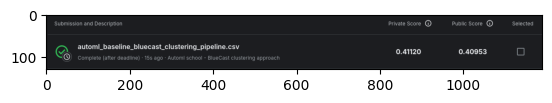

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('automl_baseline_kaggle_clustering.png')
imgplot = plt.imshow(img)
plt.show()

That would end up being in the bottom 20 of the leaderboard.